### <font color='red'>Disclaimer: This project was embarked upon as a personal exploration and for enjoyment, with the primary goals of deepening my understanding of neural networks and advancing my machine learning capabilities through practical application. It represents an exercise in applying theoretical knowledge rather than a definitive guide or strategy for outperforming any financial index, such as the SOFIX index.

</font>

### <font color='red'>The insights and outcomes presented are part of my learning journey and should not be interpreted as professional investment advice or as a reliable method for generating market alpha. While every effort has been made to ensure the accuracy and completeness of the project, it's important to acknowledge the potential for oversight or error. This endeavor is shared in the spirit of learning and should be viewed as such by its audience.

</font>


### 0. Very quickly...
As mentioned in the readme file, the code below will not be fully executable for most users.
This is because some of the data used is only available through purchase directly from the Bulgarian Stock Exchange, as I am not permitted to distribute the data in its original format.

You can contact the BSE directly if you wish to purchase the data and run the file yourself: https://www.bse-sofia.bg/en/contact-us

Regardless, I have made an effort to make the code as interpretable as possible and to visualize all relevant results so that you don't really need to be able to run the code to follow along!

### 1. Importing all relevant modules

In [1]:
# Standard library imports
import logging
import os
import re
import time

# Third-party imports for data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm


# TensorFlow and Keras imports for machine learningimport tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Configure logging for TensorFlow
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

### 2. Data set-up

#### Import the Data - create & display dataframes to understand data

* **df_intradays**: contains intraday price data for the SOFIX Index, collected every minute from when the exchange opens until it closes, for every day from the 3rd Jan 2023 until 2nd Feb 2024.
* **df_updown**: contains information as to whether the SOFIX Index has opened higher on a specifc date vs the closing level of the previous day, for every day from the 4th Jan 2023 until 5th Feb 2024. To be specific, we take the level of the SOFIX Index at 10:30AM on said date and compare it to the closing level the previous date. You will find this dataframe contains an array of 1s and 0s, where 1 = SOFIX Index at 10:30AM on today's date is higher vs yesterday's closing level, and, 0 = SOFIX Index at 10:30AM on today's date is lower vs yesterday's closing level.
* **df_sofix**: dataframe containing the closing levels of the SOFIX Index for each date. Note: As you will see later, this dataframe is not used in our deep learning model. It is used at the end in our evaluation. Eventually using the predictions made from our model we will build a strategy that aims to outperform simply being long/buying the index.  

**Natural Question to ask**: Why do we collect the intraday price and volume data from the 3rd Jan 2023 until the 2nd Feb 2024 and the up or down data from the 4th Jan 2023 till the 5th Feb 2024?

It is all to do with how we will need to map our neural network model later. In a nutshell, what our model will do is observe the intraday price behaviour on a particular date then make a prediction ***for the next day*** as to whether the index will open higher or lower. The idea is that the index might exhibit certain behaviours the previous day that will have a direct influence on the opening price.

So, for example, our model will observe the price behaviour on the 3rd Jan 2023 and then make a prediction about whether the index will be up or down on the 4th January 2023.
Hence, our data needs to be mapped as follows in our model:

- Intraday data on 3rd Jan 2023 -> Up/Down data on 4th Jan 2023
- Intraday data on 4th Jan 2023 -> Up/Down data on 5th Jan 2023
.
.
.
- Intraday data on 1st Feb 2024 -> Up/Down data on 2nd Feb 2024
- Intraday data on 2nd Feb 2024 -> Up/Down data on 5th Feb 2024

**Another question you might have:** why do we skip certain dates, etc on the last line why are we mapping 12th Jan to 15th Jan (and not the 13th)? Because markets are closed on weekends and holidays! Our data filters out days on which markets are closed.

In [2]:
file_path = r''

df_intradays = pd.read_excel(file_path, sheet_name='prices')

# Filter out price data before certain time:
df_intradays['date'] = pd.to_datetime(df_intradays['date'])

# Filter rows where the time is 17:15:00, and explicitly create a copy
df_sofix = df_intradays[df_intradays['date'].dt.time == pd.to_datetime('17:15:00').time()].copy()

# Remove the time part, keeping only the date part
df_sofix['date'] = df_sofix['date'].dt.date
df_sofix = df_sofix.reset_index().drop(columns = 'index')

# Filter rows where the time is 10:30:00, and explicitly create a copy
df_sofix_1030 = df_intradays[df_intradays['date'].dt.time == pd.to_datetime('10:30:00').time()].copy()

# Remove the time part, keeping only the date part
df_sofix_1030['date'] = df_sofix_1030['date'].dt.date
df_sofix_1030 = df_sofix_1030.reset_index().drop(columns = 'index')

# Initialize the df_updown DataFrame with 'date' from either df_sofix or df_sofix_1030
df_updown = pd.DataFrame({
    'date': df_sofix['date']
})

# Perform the comparison, shifting df_sofix_1030['level'] for comparison with df_sofix['level']
# Ensure comparison_values is of float type to accommodate NaN
comparison_values = np.where(
    df_sofix_1030['level'].iloc[1:].reset_index(drop=True) > df_sofix['level'].iloc[:-1].reset_index(drop=True), 
    1.0,  # Use 1.0 instead of 1 to ensure the array is of float type
    0.0   # Use 0.0 instead of 0 for the same reason
)

# Insert a NaN at the beginning to match the DataFrame length
comparison_values_with_nan = np.insert(comparison_values, 0, np.nan)

# Assign 'up or down?' column
df_updown['up or down?'] = comparison_values_with_nan
df_updown = df_updown[1:].reset_index().drop(columns = ['index'])

# Display the first few rows of df_updown to verify
# Filter out rows for the date 2024-02-05
df_intradays = df_intradays[df_intradays['date'].dt.date != pd.to_datetime("2024-02-05").date()]

#prep df_sofix
df_sofix = df_sofix[:-1] 

# Now df_intradays excludes rows from 2024-02-05
display(df_intradays)
display(df_updown)
display(df_sofix)


,date,level
0,2023-01-03 10:00:00,601.49
1,2023-01-03 10:01:00,601.49
2,2023-01-03 10:02:00,601.49
3,2023-01-03 10:03:00,601.49
4,2023-01-03 10:04:00,601.49
...,...,...
117602,2024-02-02 17:11:00,779.96
117603,2024-02-02 17:12:00,779.96
117604,2024-02-02 17:13:00,779.96
117605,2024-02-02 17:14:00,779.96


,date,up or down?
0,2023-01-04,0.0
1,2023-01-05,0.0
2,2023-01-06,0.0
3,2023-01-09,0.0
4,2023-01-10,1.0
...,...,...
265,2024-01-30,1.0
266,2024-01-31,0.0
267,2024-02-01,1.0
268,2024-02-02,0.0


,date,level
0,2023-01-03,602.39
1,2023-01-04,603.42
2,2023-01-05,605.13
3,2023-01-06,604.72
4,2023-01-09,607.40
...,...,...
265,2024-01-29,789.80
266,2024-01-30,787.71
267,2024-01-31,786.68
268,2024-02-01,783.52


#### Clean & format the data - convert to np.darrays & normalise the input (X) features
Next, we convert our dataframes into a format that will be understandable for our Neural Network model.
We will create X1 (which contains intraday price data), X2 (which is a replica of X1, [I explain why later]) and y (which contains information on whether the index opens up or down) all in np.darraay format, which our model will understand.
We will also normalise the input features X1 and X2. This is good practice to help better discern patterns in the data and avoid bias or missing relevant information due to scaling issues and also improves the efficiency of algorithms imbedded within the model e.g. gradient descent.

In [3]:
""" Price (X1) Data """

# Convert the 'date' column to datetime if it's not already.
df_intradays['date'] = pd.to_datetime(df_intradays['date'])

# Group by the date part of the 'date' column.
grouped = df_intradays.groupby(df_intradays['date'].dt.date)

# Initialize an empty list to hold each day's levels.
list_of_arrays = []

# Loop over the groups and create an array for each day's levels.
for _, group in grouped:
    levels_array = group['level'].to_numpy()
    # Pad the array if it is shorter than 436
    if len(levels_array) < 436:
        levels_array = np.pad(levels_array, (0, 436 - len(levels_array)), 'edge')
    list_of_arrays.append(levels_array)

# Convert the list of arrays into a NumPy array.
X1 = np.stack(list_of_arrays)
X1

array([[601.49, 601.49, 601.49, ..., 602.39, 602.39, 602.39],
       [602.39, 602.39, 602.39, ..., 603.42, 603.42, 603.42],
       [603.42, 603.42, 603.42, ..., 605.13, 605.13, 605.13],
       ...,
       [787.71, 787.71, 787.71, ..., 786.68, 786.68, 786.68],
       [786.68, 786.68, 786.68, ..., 783.52, 783.52, 783.52],
       [783.52, 783.52, 783.52, ..., 779.96, 779.96, 779.96]])

In [4]:
""" Replica of X1 (X2) Data """

X2 = X1
X2

array([[601.49, 601.49, 601.49, ..., 602.39, 602.39, 602.39],
       [602.39, 602.39, 602.39, ..., 603.42, 603.42, 603.42],
       [603.42, 603.42, 603.42, ..., 605.13, 605.13, 605.13],
       ...,
       [787.71, 787.71, 787.71, ..., 786.68, 786.68, 786.68],
       [786.68, 786.68, 786.68, ..., 783.52, 783.52, 783.52],
       [783.52, 783.52, 783.52, ..., 779.96, 779.96, 779.96]])

In [5]:
'''Normalising the price feature X1'''
X1_normalized = np.zeros_like(X1)  # Create a new array to hold the normalized data

for i in range(X1.shape[0]):  # Iterate over rows
    row_mean = X1[i, :].mean()
    row_std = X1[i, :].std()

    # Apply the z-score normalization formula to each row
    # Avoid division by zero in case row_std is 0
    X1_normalized[i, :] = (X1[i, :] - row_mean) / (row_std if row_std else 1)
X1 = X1_normalized

In [6]:
'''Normalising the replica feature X2'''
X2_normalized = np.zeros_like(X2)  # Create a new array to hold the normalized data

for i in range(X2.shape[0]):  # Iterate over rows
    row_mean = X2[i, :].mean()
    row_std = X2[i, :].std()

    # Apply the z-score normalization formula to each row
    # Avoid division by zero in case row_std is 0
    X2_normalized[i, :] = (X2[i, :] - row_mean) / (row_std if row_std else 1)
X2 = X2_normalized

##### Convert to np.darrays the output (y) features

In [7]:
""" y Data """
# Convert the 'time' column to datetime if it's not already.
df_updown['date'] = pd.to_datetime(df_updown['date'])

# Group by the date part of the 'time' column.
grouped = df_updown.groupby(df_updown['date'].dt.date)

# Initialize an empty list to hold each day's levels.
list_of_arrays = []

# Loop over the groups and create an array for each day's levels.
for _, group in grouped:
    levels_array = group['up or down?'].to_numpy()
    list_of_arrays.append(levels_array)

# Convert the list of arrays into a NumPy array of arrays.
y = np.array(list_of_arrays, dtype=object)


### 3. Splitting the Data - into training/ cross-validation (cv)/ test sets

Splitting data into training, cross-validation (CV), and test sets is a fundamental practice in machine learning and statistics. 

* **Training Set**: The training set is used to fit or train the model. The model learns to make predictions or decisions based on this data.
  
* **Cross-Validation (CV) Set**: The CV set, is used to tune the hyperparameters of the model and make decisions about the model architecture. The validation set provides a way to assess the performance of the model on unseen data without touching the test set. It helps in avoiding overfitting to the training data.
  
* **Test Set**: The test set is used to evaluate the final performance of the model after it has been trained and validated. It acts as an unbiased indicator of how the model will perform on unseen, real-world data. 

#### Choose how to split the data here

In [8]:
# Split percentages for training, cross-validation, and test sets
train_pct = 0.90 # i.e. first 90% of dataset will be used to train the model
cv_pct = 0.95 # 90-95% of dataset will be used in cv set
test_pct = 1.0  # final 5% of dataset will be used in the test set

In [9]:
def calculate_indices(total_rows, start_pct, end_pct):
    start_idx = int(np.ceil(total_rows * start_pct))
    end_idx = min(int(np.ceil(total_rows * end_pct)), total_rows)
    return start_idx, end_idx

# Initialize the datasets dictionary
datasets = {}

# Prepare datasets for X1
total_rows = X1.shape[0]
train_start, train_end = calculate_indices(total_rows, 0, train_pct)
cv_start, cv_end = calculate_indices(total_rows, train_pct, cv_pct)
test_start, test_end = calculate_indices(total_rows, cv_pct, test_pct)

datasets['X1_train'] = X1[train_start:train_end]
datasets['X1_cv'] = X1[cv_start:cv_end]
datasets['X1_test'] = X1[test_start:test_end]

# Prepare datasets for X2
total_rows = X2.shape[0]
train_start, train_end = calculate_indices(total_rows, 0, train_pct)
cv_start, cv_end = calculate_indices(total_rows, train_pct, cv_pct)
test_start, test_end = calculate_indices(total_rows, cv_pct, test_pct)

datasets['X2_train'] = X2[train_start:train_end]
datasets['X2_cv'] = X2[cv_start:cv_end]
datasets['X2_test'] = X2[test_start:test_end]

# Prepare the target (y) datasets
total_rows = y.shape[0]
train_start, train_end = calculate_indices(total_rows, 0, train_pct)
cv_start, cv_end = calculate_indices(total_rows, train_pct, cv_pct)
test_start, test_end = calculate_indices(total_rows, cv_pct, test_pct)

datasets['y_train'] = y[train_start:train_end]
datasets['y_cv'] = y[cv_start:cv_end]
datasets['y_test'] = y[test_start:test_end]

# define variables for each X1, X2 and y (train/ cv and test set):
X1_train = datasets['X1_train']
X2_train = datasets['X2_train']
X1_cv = datasets['X1_cv']
X2_cv = datasets['X2_cv']
X1_test = datasets['X1_test']
X2_test = datasets['X2_test']
y_train = datasets['y_train']
y_test = datasets['y_test']
y_cv = datasets['y_cv']

# convert to float for convenience later on:
X1_train = X1_train.astype('float32')
X2_train = X2_train.astype('float32')
X1_cv = X1_cv.astype('float32')
X2_cv = X2_cv.astype('float32')
X1_test = X1_test.astype('float32')
X2_test = X2_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_cv = y_cv.astype('float32')

# Display the shapes of the datasets
for key, value in datasets.items():
    print(f"{key}: {value.shape}")


X1_train: (243, 436)
X1_cv: (14, 436)
X1_test: (13, 436)
X2_train: (243, 436)
X2_cv: (14, 436)
X2_test: (13, 436)
y_train: (243, 1)
y_cv: (14, 1)
y_test: (13, 1)


### 4. Building the Deep Learning Model from scratch (LeakyReLU/ Segmented Approach)

**Three things to note:**

- ***Note 1:*** I have already run the code in part 4 and saved the models we build under the "final_model_candidates" folder. You can skip to the bottom of part 4 under the section titled **"Loading saved & already trained models from file path"** to load the models once saved in your local filepath. However, they will not be much use to you if you have no access to the intraday price data.

- ***Note 2:*** In the event you purchase the data and end up running the code below, the models you construct will be paramaterised differently to the ones I built and saved in the "final_model_candidates" folder. This is due to the inherent random initialisation & parametrisation in neural network models. 

- ***Note 3:*** If you do get around to building the models with the code below yourself, you will notice as you work through part 4 that I save the models within an internal filepath and then reload them. If you build the models yourself, please also save them to your own local file path and then re-load them before continuing. The code that follows Part 4 is built to handle the format of the re-loaded models. Just to be clear - the re-loaded models contain exactly the same information as before they are saved but just in a slightly different format.

**Now, moving onto the fun part! We implement a standard multi-layer perceptron neural network model with two main modifications:**

1. **LeakyReLU activation function**: This slight modification helps in mitigating the problem of "dying ReLUs," where neurons effectively die during training and stop learning, often observed with standard ReLU activation functions.
2. **Segmenting the layer configuration**:
    * The model is "segmented". Typically this kind of model is used to processes two types of input separately: e.g. if we were to have intraday prices (X1) and volume data (X2),  this architecture would allow the model to learn different features from each type of data before combining them.
    * It does this by allowing input type to go through its own series of dense layers (fully connected layers) and then the outputs of these parallel paths are concatenated.
    * In our case we have intraday prices (X1) and created a replica of the data (X2). The reason I opted to segment the model and run the same data through the same process seperately before conatenating the results is simply because it led to: (i) an increase in training data accuracy (ii) an increase in cross-validation performance and so in theory we should end up with a better model.
    * The consequences are that:
        * (i) the computation becomes more intensive => this is a cost I am willing to take for better performance.
        * (ii) risk of overfitting => a cost that seems limited since this process leads to greater cross-validation accuracy.

#### Defining the function to build and train the model:

This paramater decides where to apply the segmentation. Etc if layer configuration is [10,5,3,2,1] and Nm = 2 (i.e. we split last 3 layers, then we split as follows:
 1. [10, 5] and 2. [3, 2, 1]

In [ ]:
Nm = 2 #(split last three)
#Nm= 3 #(split last four)

In [ ]:
def build_and_train_segmented_model(layers_neurons, learning_rate, epochs, reg_factor, X1_train, X2_train, y_train):
    # Separate inputs for price and volume
    input_price = Input(shape=(X1_train.shape[1],))
    input_volume = Input(shape=(X2_train.shape[1],))

    # Process price data
    x = Dense(layers_neurons[0], kernel_regularizer=l2(reg_factor))(input_price)
    x = LeakyReLU(alpha=0.01)(x)
    for neurons in layers_neurons[1:-Nm]: # Modified to use -Nm
        x = Dense(neurons, kernel_regularizer=l2(reg_factor))(x)
        x = LeakyReLU(alpha=0.01)(x)
    price_branch = x

    # Process volume data
    y = Dense(layers_neurons[0], kernel_regularizer=l2(reg_factor))(input_volume)
    y = LeakyReLU(alpha=0.01)(y)
    for neurons in layers_neurons[1:-Nm]: # Modified to use -Nm
        y = Dense(neurons, kernel_regularizer=l2(reg_factor))(y)
        y = LeakyReLU(alpha=0.01)(y)
    volume_branch = y

    # Combine the branches
    combined = concatenate([price_branch, volume_branch])

    # Final part of the network
    for i in range(-Nm, 0):  # Loop over the last Nm layers
        if i == -1:  # If it's the last layer, use sigmoid activation
            z = Dense(layers_neurons[i], activation='sigmoid', kernel_regularizer=l2(reg_factor))(z)
        else:  # For other layers, use LeakyReLU
            z = Dense(layers_neurons[i], kernel_regularizer=l2(reg_factor))(combined)
            z = LeakyReLU(alpha=0.01)(z)
        combined = z  # Update the combined variable to be the output of the current layer


    # Create the model
    model = Model(inputs=[input_price, input_volume], outputs=z)
    model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate))
    history = model.fit([X1_train, X2_train], y_train, epochs=epochs, verbose=0)

    final_epoch_loss = history.history['loss'][-1]
    return model, final_epoch_loss


#### Building models with different architectures:

A standard procedure when building a neural network is to train the model on several different types of architectures in order to optimise the paramaterisation and reduce overfitting and variance issues. In the code that follows, I make it possible to train multiple types of model architecutres, in order to evaluate peformance of each one on the cross- validation sets. 

**Note: Below I include the code that makes it possible to test each configuration and then state and explain the choices I made. I do not include analysis of every model architecture I tested since I believe this would not add much value and make the file unecessarily longer.** 

* layer_configs = layer configuration of the MLP model. I ended up using the following configuration: **[1000, 100, 10, 5, 1]**
    * Larger configurations e.g. [1000, 100, 10, 5, 3, 2, 1] added to computational strain but did not yield better results on cross-validation sets.
    * Smaller configurations e.g. [1000,10,1] failed to discern relevant patterns and often led to overfitting on training set and poor performance on cross-validation sets.


* learning rates for Adam optimizer. I settled on **0.0001**. Larger rates penalised data fitting too harshly and performed poorly on cross-validation sets. 0.0001 and 0.001 performed best across training and cross-validation sets.
* epochs: **25**, more epochs yielded similar results and add to computational requirements. 
* l2_reg_factors: **0**, after testing higher values, I saw no improvement in performance on cross-validation set so I opted to ommit this form of regulatisation.
* N = **100** I ran 100 runs of each model configuration to test performance across large sample size to reduce bias of intepretation of different model performances.

In [ ]:
layer_configs = [
    #[1000, 100, 10, 5, 3, 2, 1],
    [1000, 100, 10, 5, 1],
    #[1000, 100, 10, 5, 3, 1],
]
learning_rates = [0.0001]
epochs_list = [25]
l2_reg_factors = [0]  # Example regularization factors

models_histories = {}


num_layer_configs = len(layer_configs)
num_learning_rates = len(learning_rates)
num_epochs_list = len(epochs_list)
num_l2_reg_factors = len(l2_reg_factors)

# To have an idea of number of models we will train. Note: I can adjust 
total_models = num_layer_configs * num_learning_rates * num_epochs_list * num_l2_reg_factors

# Number of times each model is trained
N = 100

# Number of models to be trained
print(f"Total models to be trained: {total_models*N}") 

#### Training the different model iterations

***Note: in this code I simply train N=100 runs of one model architecture which we deduced to be with the most optimised paramaterisation.***

In [ ]:
total_models = len(layer_configs) * len(learning_rates) * len(epochs_list) * len(l2_reg_factors) * N
all_models_histories = {}

pbar = tqdm(total=total_models, desc="Training Models", unit="model")

for reg_factor in l2_reg_factors:
    for layers_neurons in layer_configs:
        for lr in learning_rates:
            for epochs in epochs_list:
                for run in range(N):
                    model_key = f"model_{layers_neurons}_{lr}_epochs_{epochs}_reg_{reg_factor}_run_{run}"

                    # Fetch the training data
                    X1_train = datasets['X1_train'].astype('float32')
                    X2_train = datasets['X2_train'].astype('float32')
                    y_train = datasets['y_train'].astype('float32')

                    # Train the model
                    model, final_loss = build_and_train_segmented_model(layers_neurons, lr, epochs, reg_factor, 
                                                                        X1_train, X2_train, y_train)

                    # Store the model and loss
                    if model_key not in all_models_histories:
                        all_models_histories[model_key] = []
                    all_models_histories[model_key].append((model, final_loss))
                    pbar.update(1)


pbar.close()


In [ ]:
#all_models_histories

### Saving the trained models models to file path

In [ ]:
save_path = r""

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

def save_model(model, config_key):
    # Replace brackets and spaces in the architecture part and create the filename
    filename = f"model_{config_key.replace(' ', '').replace('[', '').replace(']', '')}.h5"
    file_path = os.path.join(save_path, filename)
    model.save(file_path)

# Calculate total number of models to save for progress bar
total_models = sum(len(model_list) for model_list in all_models_histories.values())

# Initialize tqdm progress bar
pbar = tqdm(total=total_models, desc="Saving Models", unit="model")

# Saving models with progress bar
for config_key, model_list in all_models_histories.items():
    for model, _ in model_list:
        save_model(model, config_key)
        pbar.update(1)  # Update the progress bar

# Close the progress bar
pbar.close()


### Loading saved & already trained models from file path
As mentioned, the models I use from this point on are in the "best_model_candidates" folder. Please save them locally and use the below code to load. You will need to input your file path below.

In [10]:
### Input your file path here.
load_path = r""

def load_models():
    loaded_models = {}

    # List all .h5 model files
    model_files = [f for f in os.listdir(load_path) if f.endswith('.h5')]

    # Load each model with a progress bar
    for model_file in tqdm(model_files, desc="Loading Models", unit="model"):
        model_path = os.path.join(load_path, model_file)
        model = load_model(model_path)

        # Use filename to create the config key
        config_key = model_file.replace('.h5', '').replace("model_", "config_")
        loaded_models[config_key] = model

    return loaded_models

# Load models with progress bar
loaded_models = load_models()


Loading Models: 100%|██████████████████████| 100/100 [00:06<00:00, 15.47model/s]


### 5. Evaluating the performance of our model on the training set

We build code that let's us evaluate the performance of our models on the training set. 

We define two metrics to judge the performance:

1) **"Accuracy (%)"**: defined as the % of days in which our model correctly predicts if the index opens up (=1) or down (=1).
2) **"J_cost (Loss)"**: the value of the loss function after the final epoch, as typically defined in multi-layer perceptron models.

In [11]:
all_models_histories = loaded_models

#### We define a function that lets us evaluate the performance of a specific model given X1, X2 and y data. We will call this function when evaluating on training set, cv set and test set.

In [12]:
def evaluate_model_accuracy(model, X1_data, X2_data, y_data):
    predictions = model.predict([X1_data, X2_data], verbose=0)
    predicted_classes = (predictions >= 0.5).astype(int).flatten()
    actual_classes = y_data.flatten()
    correct_predictions = np.sum(predicted_classes == actual_classes)
    
    accuracy = (correct_predictions / len(actual_classes)) * 100
    J_cost = model.evaluate([X1_data, X2_data], y_data, verbose=0)

    return correct_predictions, accuracy, J_cost


#### Defining a function to evaluate model by model the performance on the training set

In [13]:
def extract_run_number(model_key):
    # Regular expression to find the run number at the end of the string
    match = re.search(r'run_(\d+)$', model_key)
    return match.group(1) if match else 'Unknown'

results = []

# Initialize tqdm progress bar
pbar = tqdm(total=len(all_models_histories), desc="Evaluating Models on Training Set", unit="model")

for model_key, model in all_models_histories.items():
    run_number = extract_run_number(model_key)

    correct_predictions, accuracy, J_cost = evaluate_model_accuracy(model, X1_train, X2_train, y_train)
    results.append({
        "Model Specification": model_key,
        "Run": run_number,
        "Total Predictions": len(y_train),
        "Correct Predictions": correct_predictions,
        "Accuracy (%)": round(accuracy, 2),
        "J_cost (Loss)": round(J_cost, 4)
    })

    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()

results_dataframe = pd.DataFrame(results)
print("\nResults on Training Set:")
results_dataframe


Evaluating Models on Training Set: 100%|███| 100/100 [00:12<00:00,  7.90model/s]


Results on Training Set:


,Model Specification,Run,Total Predictions,Correct Predictions,Accuracy (%),J_cost (Loss)
0,"config_config_1000,100,10,5,1_0.0001_epochs_25...",50,243,241,99.18,0.1231
1,"config_config_1000,100,10,5,1_0.0001_epochs_25...",35,243,243,100.00,0.1301
2,"config_config_1000,100,10,5,1_0.0001_epochs_25...",64,243,229,94.24,0.4201
3,"config_config_1000,100,10,5,1_0.0001_epochs_25...",97,243,229,94.24,0.2587
4,"config_config_1000,100,10,5,1_0.0001_epochs_25...",87,243,243,100.00,0.0792
...,...,...,...,...,...,...
95,"config_config_1000,100,10,5,1_0.0001_epochs_25...",16,243,243,100.00,0.0690
96,"config_config_1000,100,10,5,1_0.0001_epochs_25...",47,243,241,99.18,0.2962
97,"config_config_1000,100,10,5,1_0.0001_epochs_25...",73,243,240,98.77,0.1546
98,"config_config_1000,100,10,5,1_0.0001_epochs_25...",22,243,238,97.94,0.1446


#### Building a code to aggregate the performance of each specific model architecture for comparison across configurations

**Note**: as mentioned above, we are only building the optimised configuration (with N=100 runs), hence we only have only one row in the aggregated dataframe below.

In [14]:
def parse_model_spec(spec):
    # Regex pattern to extract architecture, learning rate, epochs, and regularization
    pattern = r"config_(.*?)_(.*?)_epochs_(\d+)_reg_(.*?)_"
    match = re.search(pattern, spec)
    if match:
        architecture = match.group(1)
        learning_rate = match.group(2)
        epochs = match.group(3)
        reg_factor = match.group(4)
        return architecture, learning_rate, epochs, reg_factor
    return None, None, None, None

# Apply the function to create new columns
results_dataframe[['Architecture', 'Learning Rate', 'Epochs', 'Reg Factor']] = results_dataframe.apply(
    lambda row: pd.Series(parse_model_spec(row['Model Specification'])), axis=1
)

# Group by architecture, learning rate, epochs, and regularization factor
grouped_results = results_dataframe.groupby(['Architecture', 'Learning Rate', 'Epochs', 'Reg Factor']).agg(
    {'Total Predictions': 'mean',
     'Correct Predictions': 'mean',
     'Accuracy (%)': 'mean',
     'J_cost (Loss)': 'mean'}
).reset_index()

grouped_results


,Architecture,Learning Rate,Epochs,Reg Factor,Total Predictions,Correct Predictions,Accuracy (%),J_cost (Loss)
0,config,"1000,100,10,5,1_0.0001",25,0,243.0,239.17,98.4245,0.156691


#### Code to sort dataframe by accuracy - relevant when comparing multiple model architectures.

In [15]:
df_sorted_train = grouped_results.sort_values(by='Accuracy (%)', ascending=False)
df_sorted_train

,Architecture,Learning Rate,Epochs,Reg Factor,Total Predictions,Correct Predictions,Accuracy (%),J_cost (Loss)
0,config,"1000,100,10,5,1_0.0001",25,0,243.0,239.17,98.4245,0.156691


### 6. Evaluating the performance of our model on the cross-validation set

We build code that lets us evaluate the performance of our models on the cv set. 

As before, we define two metrics to judge the performance:

1) **"Accuracy (%)"**: defined as the % of days in which our model correctly predicts if the index opens up (=1) or down (=1).
2) **"J_cost (Loss)"**: the value of the loss function after the final epoch, as defined in multi-layer perceptron models.

In [16]:
# Evaluate each loaded model on the cross-validation dataset
start_time = time.time()  # Start timing

results_cv = []
for model_key, model in tqdm(all_models_histories.items(), desc="Evaluating Models on CV Set", unit="model"):
    # Fetch the cross-validation data
    X1_cv = datasets['X1_cv'].astype('float32')
    X2_cv = datasets['X2_cv'].astype('float32')
    y_cv = datasets['y_cv'].astype('float32')

    correct_predictions, accuracy, J_cost = evaluate_model_accuracy(model, X1_cv, X2_cv, y_cv)
    results_cv.append({
        "Model Specification": model_key,
        "Run": model_key.split('_')[-1],  # Extracting run number from the model key
        "Total Predictions": len(y_cv),
        "Correct Predictions": correct_predictions,
        "Accuracy (%)": round(accuracy, 2),
        "J_cost (Loss)": round(J_cost, 4)
    })

end_time = time.time()  # End timing
elapsed_time = end_time - start_time
print(f"\nCompleted evaluation for CV Set. Time taken: {elapsed_time:.2f} seconds.")

# Convert list to DataFrame
results_dataframe_cv = pd.DataFrame(results_cv)
print("\nResults for CV Set:")
results_dataframes_cv = results_dataframe_cv
results_dataframes_cv.sort_values(by='Accuracy (%)', ascending=False)


Evaluating Models on CV Set: 100%|█████████| 100/100 [00:04<00:00, 24.38model/s]


Completed evaluation for CV Set. Time taken: 4.11 seconds.

Results for CV Set:


,Model Specification,Run,Total Predictions,Correct Predictions,Accuracy (%),J_cost (Loss)
93,"config_config_1000,100,10,5,1_0.0001_epochs_25...",63,14,11,78.57,0.7408
51,"config_config_1000,100,10,5,1_0.0001_epochs_25...",48,14,10,71.43,0.9006
25,"config_config_1000,100,10,5,1_0.0001_epochs_25...",20,14,10,71.43,0.8395
14,"config_config_1000,100,10,5,1_0.0001_epochs_25...",15,14,10,71.43,0.8848
13,"config_config_1000,100,10,5,1_0.0001_epochs_25...",44,14,10,71.43,0.8715
...,...,...,...,...,...,...
16,"config_config_1000,100,10,5,1_0.0001_epochs_25...",21,14,6,42.86,0.7893
42,"config_config_1000,100,10,5,1_0.0001_epochs_25...",88,14,6,42.86,0.9450
53,"config_config_1000,100,10,5,1_0.0001_epochs_25...",3,14,6,42.86,1.0470
35,"config_config_1000,100,10,5,1_0.0001_epochs_25...",41,14,5,35.71,0.9439


#### Building a code to aggregate the performance of each specific model architecture for comparison across configurations

**Note**: as mentioned above, we are only running the optimised configuration (with N=100 runs), hence we only have one row in the aggregated dataframe below.

In [17]:
def parse_model_spec(spec):
    # Regex pattern to extract architecture, learning rate, epochs, and regularization
    pattern = r"config_(.*?)_(.*?)_epochs_(\d+)_reg_(.*?)_"
    match = re.search(pattern, spec)
    if match:
        architecture = match.group(1)
        learning_rate = match.group(2)
        epochs = match.group(3)
        reg_factor = match.group(4)
        return architecture, learning_rate, epochs, reg_factor
    return None, None, None, None

# Assuming results_dataframes_cv is your DataFrame
# Sample data (replace this with your actual DataFrame)
# results_dataframes_cv = ...

# Apply the function to create new columns
results_dataframes_cv[['Architecture', 'Learning Rate', 'Epochs', 'Reg Factor']] = results_dataframes_cv.apply(
    lambda row: pd.Series(parse_model_spec(row['Model Specification'])), axis=1
)

# Group by architecture, learning rate, epochs, and regularization factor
grouped_results_cv = results_dataframes_cv.groupby(['Architecture', 'Learning Rate', 'Epochs', 'Reg Factor']).agg(
    {'Total Predictions': 'mean',
     'Correct Predictions': 'mean',
     'Accuracy (%)': 'mean',
     'J_cost (Loss)': 'mean'}
).reset_index()

grouped_results_cv


,Architecture,Learning Rate,Epochs,Reg Factor,Total Predictions,Correct Predictions,Accuracy (%),J_cost (Loss)
0,config,"1000,100,10,5,1_0.0001",25,0,14.0,8.07,57.6434,0.914454


#### Code to sort dataframe by accuracy - relevant when comparing multiple model architectures.

In [18]:
df_sorted_cv = grouped_results_cv.sort_values(by='Accuracy (%)', ascending=False)
df_sorted_cv

,Architecture,Learning Rate,Epochs,Reg Factor,Total Predictions,Correct Predictions,Accuracy (%),J_cost (Loss)
0,config,"1000,100,10,5,1_0.0001",25,0,14.0,8.07,57.6434,0.914454


### 7. Evaluating the performance of our model on the test set

We build code that lets us evaluate the performance of our models on the test set. 

As before, we define two metrics to judge the performance:

1) **"Accuracy (%)"**: defined as the % of days in which our model correctly predicts if the index opens up (=1) or down (=1).
2) **"J_cost (Loss)"**: the value of the loss function after the final epoch, as defined in multi-layer perceptron models.

In [19]:
def evaluate_model_accuracy(model, X1_data, X2_data, y_data):
    predictions = model.predict([X1_data, X2_data], verbose=0)
    predicted_classes = (predictions >= 0.5).astype(int).flatten()
    actual_classes = y_data.flatten()
    correct_predictions = np.sum(predicted_classes == actual_classes)
    
    accuracy = (correct_predictions / len(actual_classes)) * 100
    J_cost = model.evaluate([X1_data, X2_data], y_data, verbose=0)

    return correct_predictions, accuracy, J_cost

results = []

start_time = time.time()  # Start timing

for model_key, model in tqdm(all_models_histories.items(), desc="Evaluating Models on Test Set", unit="model"):
    X1_test = datasets['X1_test'].astype('float32')
    X2_test = datasets['X2_test'].astype('float32')
    y_test = datasets['y_test'].astype('float32')

    correct_predictions, accuracy, J_cost = evaluate_model_accuracy(model, X1_test, X2_test, y_test)
    results.append({
        "Model Specification": model_key,
        "Run": model_key.split('_')[-1],  # Extracting run number from the model key
        "Total Predictions": len(y_test),
        "Correct Predictions": correct_predictions,
        "Accuracy (%)": round(accuracy, 2),
        "J_cost (Loss)": round(J_cost, 4)
    })

end_time = time.time()  # End timing
elapsed_time = end_time - start_time

results_dataframe_test = pd.DataFrame(results)
print("\nResults for Test Set Evaluation:")
print(results_dataframe_test)
print(f"\nTotal evaluation time: {elapsed_time:.2f} seconds.")


Evaluating Models on Test Set: 100%|███████| 100/100 [00:04<00:00, 23.21model/s]


Results for Test Set Evaluation:
                                  Model Specification Run  Total Predictions  \
0   config_config_1000,100,10,5,1_0.0001_epochs_25...  50                 13   
1   config_config_1000,100,10,5,1_0.0001_epochs_25...  35                 13   
2   config_config_1000,100,10,5,1_0.0001_epochs_25...  64                 13   
3   config_config_1000,100,10,5,1_0.0001_epochs_25...  97                 13   
4   config_config_1000,100,10,5,1_0.0001_epochs_25...  87                 13   
..                                                ...  ..                ...   
95  config_config_1000,100,10,5,1_0.0001_epochs_25...  16                 13   
96  config_config_1000,100,10,5,1_0.0001_epochs_25...  47                 13   
97  config_config_1000,100,10,5,1_0.0001_epochs_25...  73                 13   
98  config_config_1000,100,10,5,1_0.0001_epochs_25...  22                 13   
99  config_config_1000,100,10,5,1_0.0001_epochs_25...  80                 13   

    C

In [20]:
results_dataframe_test

,Model Specification,Run,Total Predictions,Correct Predictions,Accuracy (%),J_cost (Loss)
0,"config_config_1000,100,10,5,1_0.0001_epochs_25...",50,13,7,53.85,1.0529
1,"config_config_1000,100,10,5,1_0.0001_epochs_25...",35,13,6,46.15,0.9663
2,"config_config_1000,100,10,5,1_0.0001_epochs_25...",64,13,4,30.77,1.0933
3,"config_config_1000,100,10,5,1_0.0001_epochs_25...",97,13,6,46.15,1.0439
4,"config_config_1000,100,10,5,1_0.0001_epochs_25...",87,13,8,61.54,0.9953
...,...,...,...,...,...,...
95,"config_config_1000,100,10,5,1_0.0001_epochs_25...",16,13,6,46.15,1.0692
96,"config_config_1000,100,10,5,1_0.0001_epochs_25...",47,13,7,53.85,0.7912
97,"config_config_1000,100,10,5,1_0.0001_epochs_25...",73,13,6,46.15,1.1017
98,"config_config_1000,100,10,5,1_0.0001_epochs_25...",22,13,4,30.77,1.3776


#### Building a code to aggregate the performance of each specific model architecture for comparison across configurations

**Note**: as mentioned above, we are observing only the optimised configuration (with N=100 runs), hence we only have one row in the aggregated dataframe below.

In [21]:
def parse_model_spec(spec):
    # Regex pattern to extract architecture, learning rate, epochs, and regularization
    pattern = r"config_(.*?)_(.*?)_epochs_(\d+)_reg_(.*?)_"
    match = re.search(pattern, spec)
    if match:
        architecture = match.group(1)
        learning_rate = match.group(2)
        epochs = match.group(3)
        reg_factor = match.group(4)
        return architecture, learning_rate, epochs, reg_factor
    return None, None, None, None

# Assuming results_dataframe_test is your DataFrame
# Sample data (replace this with your actual DataFrame)
# results_dataframe_test = ...

# Apply the function to create new columns
results_dataframe_test[['Architecture', 'Learning Rate', 'Epochs', 'Reg Factor']] = results_dataframe_test.apply(
    lambda row: pd.Series(parse_model_spec(row['Model Specification'])), axis=1
)

# Group by architecture, learning rate, epochs, and regularization factor
grouped_results_test = results_dataframe_test.groupby(['Architecture', 'Learning Rate', 'Epochs', 'Reg Factor']).agg(
    {'Total Predictions': 'mean',
     'Correct Predictions': 'mean',
     'Accuracy (%)': 'mean',
     'J_cost (Loss)': 'mean'}
).reset_index()

grouped_results_test


,Architecture,Learning Rate,Epochs,Reg Factor,Total Predictions,Correct Predictions,Accuracy (%),J_cost (Loss)
0,config,"1000,100,10,5,1_0.0001",25,0,13.0,6.16,47.3844,1.025916


#### Code to sort dataframe by accuracy - relevant when comparing multiple model architectures.

In [22]:
df_sorted_test = grouped_results_test.sort_values(by='Accuracy (%)', ascending=False)
df_sorted_test

,Architecture,Learning Rate,Epochs,Reg Factor,Total Predictions,Correct Predictions,Accuracy (%),J_cost (Loss)
0,config,"1000,100,10,5,1_0.0001",25,0,13.0,6.16,47.3844,1.025916


### 8. Selecting the best model

* Below I build a code that lets us filter out any models with worse than X% accuracy on the training set, worse than Y% accuracy on the cv set or worse than Z% accuracy on the test set.

* For obvious reasons we will filter based on X and Y values and then use Z as the unbiased metric by which we measure of our chosen models performance. Why? Because if we use the results on the test set in any way to influence the model we choose, then we bias those results and no longer have a fair way to evaluate performance.

* If you recall, the average performance of all models we trained under this configuration is **approx. 98%** for the training set. As such, I am much more concerned about performance on the cv set than on the training set.

* Hence, I filter to find the model with highest performance on the cross-validation set, without paying too much attention to its corresponding training set performance. I am left with 10 models with 70%+ performance on cv set.

In [23]:
pd.set_option('display.max_colwidth', None)

In [24]:
# Set our accuracy thresholds to only include models that perform with >70% accuracy on cv set.
X = 0  # Threshold for training set accuracy set to = 0, since all models 
Y = 70  # Threshold for cross-validation set accuracy
Z = 0  # Threshold for test set accuracy

# Filter DataFrames based on accuracy
filtered_train = results_dataframe[results_dataframe['Accuracy (%)'] > X]
filtered_cv = results_dataframes_cv[results_dataframes_cv['Accuracy (%)'] > Y]
filtered_test = results_dataframe_test[results_dataframe_test['Accuracy (%)'] > Z]

# Merge the filtered results to get the best models
best_models = filtered_train.merge(filtered_test, on='Model Specification', suffixes=('_train', '_test'))
best_models = best_models.merge(filtered_cv, on='Model Specification')

# Select relevant columns and rename for clarity
best_models = best_models[['Model Specification', 'Run_train', 'Accuracy (%)_train', 'Accuracy (%)', 'Accuracy (%)_test', 'J_cost (Loss)']]
best_models.rename(columns={'Run_train': 'Run', 
                            'Accuracy (%)_train': 'Accuracy Train (%)', 
                            'Accuracy (%)_test': 'Accuracy Test (%)', 
                            'Accuracy (%)': 'Accuracy CV (%)'}, inplace=True)

best_models


,Model Specification,Run,Accuracy Train (%),Accuracy CV (%),Accuracy Test (%),J_cost (Loss)
0,"config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_44",44,99.18,71.43,38.46,0.8715
1,"config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_15",15,99.59,71.43,30.77,0.8848
2,"config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_20",20,98.35,71.43,46.15,0.8395
3,"config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_68",68,100.00,71.43,38.46,0.8221
4,"config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_48",48,100.00,71.43,38.46,0.9006
5,"config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_91",91,100.00,71.43,46.15,0.8811
6,"config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_23",23,97.94,71.43,61.54,0.7722
7,"config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_52",52,100.00,71.43,53.85,0.9148
8,"config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_43",43,93.42,71.43,53.85,0.6958
9,"config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_63",63,99.18,78.57,46.15,0.7408


#### Our best model/s: 

There is an element of subjectivity about how we are to pick the "top models". Again, our methodology here can only rely on the training and cross validation sets, we must leave the test set for final performance analysis only.

Recall we defined Accuracy as the % of days on which the model correctly predicts if the index is opening up or down. This is a nice measure of model performance at it is most interpretable but it is also important to take into account the value of the loss function which is a more mathematically accurate way of predicting which model is performing best.

Finally recall that due to the fact that the average performance of all models on the training sets is very high (98%) we are only really interested in the cv performances of the models to make our model prediction.

Above we have filtered for models above 70% accuracy on the cv set, leaving us with our top 10 candidates. 

Out of these models, **Run 43** has the highest accuracy on the cv set (78.57%) and the lowest J_cost (0.6958). For me this makes it a natural pick as our "top model".
But let us consider other models also in order to get a more complete picture of our methodology. We want to be sure we didn't just get lucky and train one good model but that rather we have devised a methodology that creates several models that all perform well. 
The rest of the top 10 models have the same accuracy (71.43%) on the cv set. But **Run 63** and **Run 23** have the next lowest J_costs, so these are our other top picks.

1)
* Configuration: config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_43
* Run: 43
* Accuracy on test set: 53.85%
* Loss on test set: 0.6958

2)
* Configuration: config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_63
* Run: 63
* Accuracy on test set: 46.15%
* Loss on test set: 0.7408

3)
* Configuration: config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_23
* Run: 23
* Accuracy on test set: 61.54%
* Loss on test set: 0.7722


Note: The other top ten accuracy runs are: 44, 15, 20, 68, 48, 91 and 52.

Other comments: Accuracy on test set could fluctuate a lot for several reasons. Etc: low accuracy could be because we are evaluating on days where market activity is particularly muted and not exhibiting predictive characteristics. Low (or high) accuracy is not the ultimate measure of model performance. 

Due to the noise around financial markets, it may be that the model can only learn to discern patterns when they are most obvious. I.e. when there is a larger than usual price movement upwards or downwards. 

This could mean that even a model with lower accuracy could perform well from an investing perspective if it learns to capture and predict the biggest price swings. As you will see later, this is exactly the case for some of the models above. For example we will see how the run 15 model, which exhibits only 30.77% accuracy on the test set, performs well in a financial context. We will show this later, but the reason is simple... the model might be wrong for small movements, but it is correct for significant moves. 

### 9. Saving our best model to file path for later use if needed

You can skip this section.

In [ ]:
dict_best_models = {}

for index, row in best_models.iterrows():
    model_spec = row['Model Specification']
    
    # Check if the model specification is in the loaded_models dictionary
    if model_spec in loaded_models:
        dict_best_models[model_spec] = loaded_models[model_spec]
    else:
        print(f"Model with specification '{model_spec}' not found in loaded_models.")

# dict_best_models now contains only the best models


In [ ]:
dict_best_models

In [ ]:
save_path = r""

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

def save_model(model, model_spec):
    # Create a filename from the model specification
    filename = f"{model_spec}.h5"
    file_path = os.path.join(save_path, filename)
    model.save(file_path)

# Iterate through dict_best_models and save each model
for model_spec, model in dict_best_models.items():
    save_model(model, model_spec)
    print(f"Saved model: {model_spec}")


### 10. Building an investment strategy utilising our deep learning models predictions.

The strategy we build is simple. Recall that the results of our NN model predict whether on each date the index will open up (y=1) or down (y=0) versus yesterday's close. 

We use the model predictions as follows:
* If the model predicts the index will **open up**, then our stragey will **buy** the index during this timeframe and go **"long"** the performance.
* If the model predicts the index will **open down**, then our stragey will **sell** the index during this timeframe and go **"short"** the performance.
 
We will evaluate the performance of our strategy by comparing it to simply being "long" the index during the same periods.

The idea being simple: can we build a strategy that beats the performance of long-only investors of the index utilising deep learning predictions?

#### First we specify the model (first lets run Model 1 i.e. run 43) whose predictions we will use within our strategy

In [25]:
# Assuming you have a dictionary all_models_histories with models
model_key = 'config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_43'  # run_43 selected
selected_model = all_models_histories[model_key]

# Assuming you have prepared your datasets as numpy arrays and stored them in a dictionary
datasets = {
    'X1_train': X1_train, 'X2_train': X2_train, 'y_train': y_train,
    'X1_cv': X1_cv, 'X2_cv': X2_cv, 'y_cv': y_cv,
    'X1_test': X1_test, 'X2_test': X2_test, 'y_test': y_test
}


#### We first define a function that builds us a dataframe "df_probabilities" which contains the following columns:

* **"up_down_prediction"**: the models prediction for whether the index opens up (=1) or down(=1) for that date.
* **"up_down_actual"**: what the index actually does on that date.
* **"probability"**: not used within our strategy but included for completeness. It is the probability assigned by the model of the index being up (=1) on that date. Note: the model predicts up (=1) if probability is greater than 0.5 and it predicts down (=0) otherwise.
* **"data_set"**: specifies to which dataset i.e. training, cv or test set that the data on that date corresponds. Important since we need to evaluate our strategy on on test set.
* **"prediction_correct?"**: a column that =1 if the model prediction is correct (i.e. up_down_prediction = up_down_actual) and =0 if not.
* **"date"**: specifies the date the row corresponds to.

In [26]:
def create_predictions_dataframe(model, datasets):
    df_probabilities = pd.DataFrame()

    for data_type in ['train', 'cv', 'test']:
        X1_data = datasets[f'X1_{data_type}'].astype('float32')
        X2_data = datasets[f'X2_{data_type}'].astype('float32')
        y_data = datasets[f'y_{data_type}'].astype('float32').flatten()

        probabilities = model.predict([X1_data, X2_data], verbose=0).flatten()
        predictions = (probabilities >= 0.5).astype(int)

        temp_df = pd.DataFrame({
            'up_down_prediction': predictions,
            'up_down_actual': y_data,
            'probability': probabilities,
            'data_set': data_type
        })

        # Calculate if prediction is correct
        temp_df['prediction_correct?'] = (temp_df['up_down_prediction'] == temp_df['up_down_actual']).astype(int)

        df_probabilities = pd.concat([df_probabilities, temp_df], ignore_index=True)

    return df_probabilities


# Original code to create DataFrame and calculate overall statistics
df_probabilities = create_predictions_dataframe(selected_model, datasets)

num_correct_predictions = df_probabilities['prediction_correct?'].sum()
total_predictions = len(df_probabilities)
accuracy = (num_correct_predictions / total_predictions) * 100

#add date column
df_probabilities['date'] = df_updown['date']

# Display the DataFrame and overall statistics
display(df_probabilities)

print(f"\nOverall - Number of correct predictions: {num_correct_predictions}")
print(f"Overall - Total number of predictions: {total_predictions}")
print(f"Overall - Accuracy of predictions: {accuracy:.2f}%")

# Additional code to calculate and display statistics for each dataset type
for data_set in ['train', 'cv', 'test']:
    subset = df_probabilities[df_probabilities['data_set'] == data_set]
    num_correct_predictions_subset = subset['prediction_correct?'].sum()
    total_predictions_subset = len(subset)
    accuracy_subset = (num_correct_predictions_subset / total_predictions_subset) * 100 if total_predictions_subset > 0 else 0

    print(f"\n{data_set.upper()} Set - Number of correct predictions: {num_correct_predictions_subset}")
    print(f"{data_set.upper()} Set - Total number of predictions: {total_predictions_subset}")
    print(f"{data_set.upper()} Set - Accuracy of predictions: {accuracy_subset:.2f}%")


,up_down_prediction,up_down_actual,probability,data_set,prediction_correct?,date
0,0,0.0,0.276610,train,1,2023-01-04
1,0,0.0,0.084984,train,1,2023-01-05
2,1,0.0,0.617321,train,0,2023-01-06
3,0,0.0,0.181667,train,1,2023-01-09
4,1,1.0,0.767949,train,1,2023-01-10
...,...,...,...,...,...,...
265,0,1.0,0.389634,test,0,2024-01-30
266,0,0.0,0.413309,test,1,2024-01-31
267,0,1.0,0.223033,test,0,2024-02-01
268,1,0.0,0.856300,test,0,2024-02-02



Overall - Number of correct predictions: 244
Overall - Total number of predictions: 270
Overall - Accuracy of predictions: 90.37%

TRAIN Set - Number of correct predictions: 227
TRAIN Set - Total number of predictions: 243
TRAIN Set - Accuracy of predictions: 93.42%

CV Set - Number of correct predictions: 10
CV Set - Total number of predictions: 14
CV Set - Accuracy of predictions: 71.43%

TEST Set - Number of correct predictions: 7
TEST Set - Total number of predictions: 13
TEST Set - Accuracy of predictions: 53.85%


#### Next we build the "df_sofix_1030" dataframe which contains the following columns:

* **"date"**: specifies the date the row belongs to.
* **"level_1030"**: the level of the index at 10:30AM on that particular date.
* **"level_eod"**: the end of day level of the index on that particular date.
* **"perf_close_1030"**: the performance of the index from yesterday's close to 10:30AM today.
* **"index_close_1030"**: a column corresponding to an index (starting at 100) capturing the performance of being long the performance of the index between index close and 10:30AM the next day, every day.

In [31]:

# Assuming df_intradays is your original dataframe
# Convert the 'date' column to datetime if it's not already
df_intradays['date'] = pd.to_datetime(df_intradays['date'])

# Filter rows where the time is 20:30:00
df_filtered = df_intradays[df_intradays['date'].dt.time == pd.to_datetime('10:30:00').time()]

# Remove the time part, leaving only the date in yyyy-mm-dd format
df_filtered['date'] = df_filtered['date'].dt.date
df_filtered = df_filtered.reset_index().drop(columns='index')
df_sofix_1030 = df_filtered


df_sofix_1030['level_eod'] = df_sofix['level']

df_sofix_1030['perf_close_1030'] = 0.0
df_sofix_1030 = df_sofix_1030.rename(columns={"level": "level_1030"})

# Iterating over the DataFrame rows starting from the second row (index 1)
for i in range(1, len(df_sofix_1030)):
    level_1030_current = df_sofix_1030.iloc[i]['level_1030']
    level_eod_previous = df_sofix_1030.iloc[i-1]['level_eod']
    df_sofix_1030.iloc[i, df_sofix_1030.columns.get_loc('perf_close_1030')] = (level_1030_current / level_eod_previous) - 1


# Initialize the index column
df_sofix_1030['index_close_1030'] = 100  # Starting value

# Iterating over the DataFrame rows
for i in range(1, len(df_sofix_1030)):
    # Calculate the new index value
    df_sofix_1030.loc[i, 'index_close_1030'] = df_sofix_1030.loc[i-1, 'index_close_1030'] * (1 + df_sofix_1030.loc[i, 'perf_close_1030'])

# Display the resulting dataframe
display(df_sofix_1030)


/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/3776496676.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = df_filtered['date'].dt.date
/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/3776496676.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '99.91382453349243' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sofix_1030.loc[i, 'index_close_1030'] = df_sofix_1030.loc[i-1, 'index_close_1030'] * (1 + df_sofix_1030.loc[i, 'perf_close_1030'])


,date,level_1030,level_eod,perf_close_1030,index_close_1030
0,2023-01-03,601.49,602.39,0.000000,100.000000
1,2023-01-04,602.39,603.42,0.000000,100.000000
2,2023-01-05,602.90,605.13,-0.000862,99.913825
3,2023-01-06,604.87,604.72,-0.000430,99.870896
4,2023-01-09,604.72,607.40,0.000000,99.870896
...,...,...,...,...,...
265,2024-01-29,788.80,789.80,0.001371,102.897921
266,2024-01-30,789.83,787.71,0.000038,102.901829
267,2024-01-31,783.49,786.68,-0.005357,102.350553
268,2024-02-01,787.32,783.52,0.000814,102.433820


#### Finally, we build the code that implements the strategy previously discussed:

The strategy we build is simple. Recall that the results of our NN model predict whether on each date the index will open up (y=1) or down (y=0) versus yesterday's close. 

We use the model predictions as follows:
* If the model predicts the index will **open up**, then our stragey will **buy** the index during this timeframe and go **"long"** the performance.
* If the model predicts the index will **open down**, then our stragey will **sell** the index during this timeframe and go **"short"** the performance.

We add to our "df_sofix_1030" dataframe the column "strategy_index" which represents the performance of this strategy in the form of an index (starting at 100).

In [32]:
# Initialize the strategy index column
df_sofix_1030['strategy_index'] = 100  # Starting value

# Iterating over the DataFrame rows
for i in range(1, len(df_sofix_1030)):
    # Check the prediction from df_probabilities
    prediction = df_probabilities.loc[i-1, 'up_down_prediction']
    
    # Update the strategy index based on the prediction
    if prediction == 1:
        # If prediction is 1, multiply by (1 + perf_close_1030)
        df_sofix_1030.loc[i, 'strategy_index'] = df_sofix_1030.loc[i-1, 'strategy_index'] * (1 + df_sofix_1030.loc[i, 'perf_close_1030'])
    else:
        # If prediction is 0, also multiply by (1 + perf_close_1030)
        df_sofix_1030.loc[i, 'strategy_index'] = df_sofix_1030.loc[i-1, 'strategy_index'] * (1 - df_sofix_1030.loc[i, 'perf_close_1030'])

# Ensure the 'date' column in both dataframes is of datetime type
df_sofix_1030['date'] = pd.to_datetime(df_sofix_1030['date'])
df_probabilities['date'] = pd.to_datetime(df_probabilities['date'])

# Merge df_sofix_1030 with df_probabilities on 'date' to get the 'data_set' column
df_sofix_1030 = pd.merge(df_sofix_1030, df_probabilities[['date', 'data_set']], on='date', how='left')

df_sofix_1030['data_set'][0] = 'train'

# Display the resulting dataframe
display(df_sofix_1030)


/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/2457070454.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '100.08617546650757' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sofix_1030.loc[i, 'strategy_index'] = df_sofix_1030.loc[i-1, 'strategy_index'] * (1 - df_sofix_1030.loc[i, 'perf_close_1030'])
/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/2457070454.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sofix_1030['data_set'][0] = 'train'


,date,level_1030,level_eod,perf_close_1030,index_close_1030,strategy_index,data_set
0,2023-01-03,601.49,602.39,0.000000,100.000000,100.000000,train
1,2023-01-04,602.39,603.42,0.000000,100.000000,100.000000,train
2,2023-01-05,602.90,605.13,-0.000862,99.913825,100.086175,train
3,2023-01-06,604.87,604.72,-0.000430,99.870896,100.043172,train
4,2023-01-09,604.72,607.40,0.000000,99.870896,100.043172,train
...,...,...,...,...,...,...,...
265,2024-01-29,788.80,789.80,0.001371,102.897921,159.167937,test
266,2024-01-30,789.83,787.71,0.000038,102.901829,159.161892,test
267,2024-01-31,783.49,786.68,-0.005357,102.350553,160.014570,test
268,2024-02-01,787.32,783.52,0.000814,102.433820,159.884391,test


#### We split our dataframe into data corresponding to the training, cv and test set respectively.

In [33]:
df_strategy_train = df_sofix_1030[df_sofix_1030['data_set'] == 'train']

df_strategy_cv = df_sofix_1030[df_sofix_1030['data_set'] == 'cv']
df_strategy_cv = df_strategy_cv.reset_index().drop(columns = 'index')

df_strategy_test = df_sofix_1030[df_sofix_1030['data_set'] == 'test']
df_strategy_test = df_strategy_test.reset_index().drop(columns = 'index')


In [34]:
display(df_strategy_train)
display(df_strategy_cv)
display(df_strategy_test)


,date,level_1030,level_eod,perf_close_1030,index_close_1030,strategy_index,data_set
0,2023-01-03,601.49,602.39,0.000000,100.000000,100.000000,train
1,2023-01-04,602.39,603.42,0.000000,100.000000,100.000000,train
2,2023-01-05,602.90,605.13,-0.000862,99.913825,100.086175,train
3,2023-01-06,604.87,604.72,-0.000430,99.870896,100.043172,train
4,2023-01-09,604.72,607.40,0.000000,99.870896,100.043172,train
...,...,...,...,...,...,...,...
239,2023-12-18,747.20,743.83,0.002522,103.219122,152.809900,train
240,2023-12-19,744.47,744.68,0.000860,103.307933,152.941379,train
241,2023-12-20,745.06,742.27,0.000510,103.360650,153.019423,train
242,2023-12-21,743.97,740.77,0.002290,103.597374,153.369879,train


,date,level_1030,level_eod,perf_close_1030,index_close_1030,strategy_index,data_set
0,2023-12-28,741.60,742.09,0.000850,103.602874,153.622538,cv
1,2023-12-29,743.65,765.12,0.002102,103.820665,153.945479,cv
2,2024-01-02,769.49,768.87,0.005712,104.413639,154.824742,cv
3,2024-01-03,758.24,757.78,-0.013825,102.970070,156.965269,cv
4,2024-01-04,758.71,764.52,0.001227,103.096442,157.157907,cv
5,2024-01-05,764.45,766.84,-0.000092,103.087002,157.172297,cv
6,2024-01-08,767.52,758.55,0.000887,103.178415,157.032923,cv
7,2024-01-09,758.75,767.21,0.000264,103.205619,157.074327,cv
8,2024-01-10,767.21,763.63,0.000000,103.205619,157.074327,cv
9,2024-01-11,759.93,769.78,-0.004845,102.705559,156.313258,cv


,date,level_1030,level_eod,perf_close_1030,index_close_1030,strategy_index,data_set
0,2024-01-18,774.36,777.23,0.000750,102.674389,156.255574,test
1,2024-01-19,778.74,782.93,0.001943,102.873865,156.559146,test
2,2024-01-22,789.17,781.82,0.007970,103.693776,157.806932,test
3,2024-01-23,784.78,778.21,0.003786,104.086364,158.404395,test
4,2024-01-24,774.79,783.72,-0.004395,103.628936,159.100535,test
5,2024-01-25,780.78,782.07,-0.003751,103.240189,159.697376,test
6,2024-01-26,778.41,787.72,-0.004680,102.757036,158.950010,test
7,2024-01-29,788.80,789.80,0.001371,102.897921,159.167937,test
8,2024-01-30,789.83,787.71,0.000038,102.901829,159.161892,test
9,2024-01-31,783.49,786.68,-0.005357,102.350553,160.014570,test


#### First let us look at the performance of our strategy on the cross-validation set.

Recall we screened for it to perform well here, so we expect our strategy to perform incredibly strongly on this timeframe. Note, this is NOT a good measure of the predictive capablities of our model.

In [35]:
# We normalise the performances starting at 100 level for each of the data sets, in order to allow easier comparison. 
# We do this for both the long only performance and our strategy performance.

# Initialize the new columns with the starting value of 100
df_strategy_cv['long_only_perf'] = 100
df_strategy_cv['strategy_perf'] = 100

# Calculate the percentage changes in the original columns
df_strategy_cv['index_close_1030_pct_change'] = df_strategy_cv['index_close_1030'].pct_change()
df_strategy_cv['strategy_index_pct_change'] = df_strategy_cv['strategy_index'].pct_change()

# Apply the percentage changes to the new columns
for i in range(1, len(df_strategy_cv)):
    df_strategy_cv.loc[i, 'long_only_perf'] = df_strategy_cv.loc[i-1, 'long_only_perf'] * (1 + df_strategy_cv.loc[i, 'index_close_1030_pct_change'])
    df_strategy_cv.loc[i, 'strategy_perf'] = df_strategy_cv.loc[i-1, 'strategy_perf'] * (1 + df_strategy_cv.loc[i, 'strategy_index_pct_change'])

# Drop the temporary pct_change columns
df_strategy_cv.drop(['index_close_1030_pct_change', 'strategy_index_pct_change'], axis=1, inplace=True)

# Display the resulting DataFrame
display(df_strategy_cv)


/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/1614972997.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '100.21021708957134' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_strategy_cv.loc[i, 'long_only_perf'] = df_strategy_cv.loc[i-1, 'long_only_perf'] * (1 + df_strategy_cv.loc[i, 'index_close_1030_pct_change'])
/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/1614972997.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '100.21021708957134' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_strategy_cv.loc[i, 'strategy_perf'] = df_strategy_cv.loc[i-1, 'strategy_perf'] * (1 + df_strategy_cv.loc[i, 'strategy_index_pct_change'])


,date,level_1030,level_eod,perf_close_1030,index_close_1030,strategy_index,data_set,long_only_perf,strategy_perf
0,2023-12-28,741.60,742.09,0.000850,103.602874,153.622538,cv,100.000000,100.000000
1,2023-12-29,743.65,765.12,0.002102,103.820665,153.945479,cv,100.210217,100.210217
2,2024-01-02,769.49,768.87,0.005712,104.413639,154.824742,cv,100.782570,100.782570
3,2024-01-03,758.24,757.78,-0.013825,102.970070,156.965269,cv,99.389202,102.175938
4,2024-01-04,758.71,764.52,0.001227,103.096442,157.157907,cv,99.511179,102.301335
5,2024-01-05,764.45,766.84,-0.000092,103.087002,157.172297,cv,99.502068,102.310702
6,2024-01-08,767.52,758.55,0.000887,103.178415,157.032923,cv,99.590302,102.219977
7,2024-01-09,758.75,767.21,0.000264,103.205619,157.074327,cv,99.616560,102.246929
8,2024-01-10,767.21,763.63,0.000000,103.205619,157.074327,cv,99.616560,102.246929
9,2024-01-11,759.93,769.78,-0.004845,102.705559,156.313258,cv,99.133890,101.751514


#### We plot performance of our strategy for the CV set, as expected, it performs very well on this dataset.

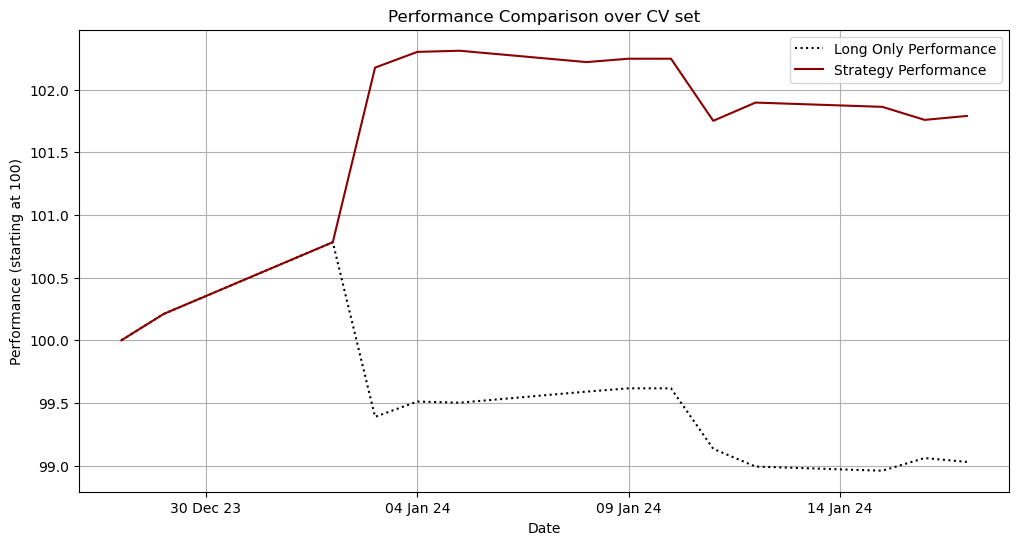

In [36]:
# Convert 'date' to datetime if it's not already
df_strategy_cv['date'] = pd.to_datetime(df_strategy_cv['date'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_strategy_cv['date'], df_strategy_cv['long_only_perf'], label='Long Only Performance', linestyle=':', color='black')
plt.plot(df_strategy_cv['date'], df_strategy_cv['strategy_perf'], label='Strategy Performance', color='darkred')

# Formatting the date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # adjust the interval as needed

# Adding titles and labels
plt.title('Performance Comparison over CV set')
plt.xlabel('Date')
plt.ylabel('Performance (starting at 100)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


#### Now time for the real test, let us do the same but for the test set, and see how well our model behaves on unseen data:

In [37]:
# again let's normalise first the performance...

# Initialize the new columns with the starting value of 100
df_strategy_test['long_only_perf'] = 100
df_strategy_test['strategy_perf'] = 100

# Calculate the percentage changes in the original columns
df_strategy_test['index_close_1030_pct_change'] = df_strategy_test['index_close_1030'].pct_change()
df_strategy_test['strategy_index_pct_change'] = df_strategy_test['strategy_index'].pct_change()

# Apply the percentage changes to the new columns
for i in range(1, len(df_strategy_test)):
    df_strategy_test.loc[i, 'long_only_perf'] = df_strategy_test.loc[i-1, 'long_only_perf'] * (1 + df_strategy_test.loc[i, 'index_close_1030_pct_change'])
    df_strategy_test.loc[i, 'strategy_perf'] = df_strategy_test.loc[i-1, 'strategy_perf'] * (1 + df_strategy_test.loc[i, 'strategy_index_pct_change'])

# Drop the temporary pct_change columns
df_strategy_test.drop(['index_close_1030_pct_change', 'strategy_index_pct_change'], axis=1, inplace=True)

# Display the resulting DataFrame
display(df_strategy_test)


/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/4221670890.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '100.19427968554997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_strategy_test.loc[i, 'long_only_perf'] = df_strategy_test.loc[i-1, 'long_only_perf'] * (1 + df_strategy_test.loc[i, 'index_close_1030_pct_change'])
/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/4221670890.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '100.19427968554997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_strategy_test.loc[i, 'strategy_perf'] = df_strategy_test.loc[i-1, 'strategy_perf'] * (1 + df_strategy_test.loc[i, 'strategy_index_pct_change'])


,date,level_1030,level_eod,perf_close_1030,index_close_1030,strategy_index,data_set,long_only_perf,strategy_perf
0,2024-01-18,774.36,777.23,0.000750,102.674389,156.255574,test,100.000000,100.000000
1,2024-01-19,778.74,782.93,0.001943,102.873865,156.559146,test,100.194280,100.194280
2,2024-01-22,789.17,781.82,0.007970,103.693776,157.806932,test,100.992834,100.992834
3,2024-01-23,784.78,778.21,0.003786,104.086364,158.404395,test,101.375197,101.375197
4,2024-01-24,774.79,783.72,-0.004395,103.628936,159.100535,test,100.929683,101.820711
5,2024-01-25,780.78,782.07,-0.003751,103.240189,159.697376,test,100.551062,102.202675
6,2024-01-26,778.41,787.72,-0.004680,102.757036,158.950010,test,100.080494,101.724378
7,2024-01-29,788.80,789.80,0.001371,102.897921,159.167937,test,100.217709,101.863846
8,2024-01-30,789.83,787.71,0.000038,102.901829,159.161892,test,100.221516,101.859977
9,2024-01-31,783.49,786.68,-0.005357,102.350553,160.014570,test,99.684599,102.405672


#### And plotting the performance vs the long-only strategy...

You can see our models predictions lead to strong performance in our strategy even under the test set. Our strategy outperforms being long only by over 2%!

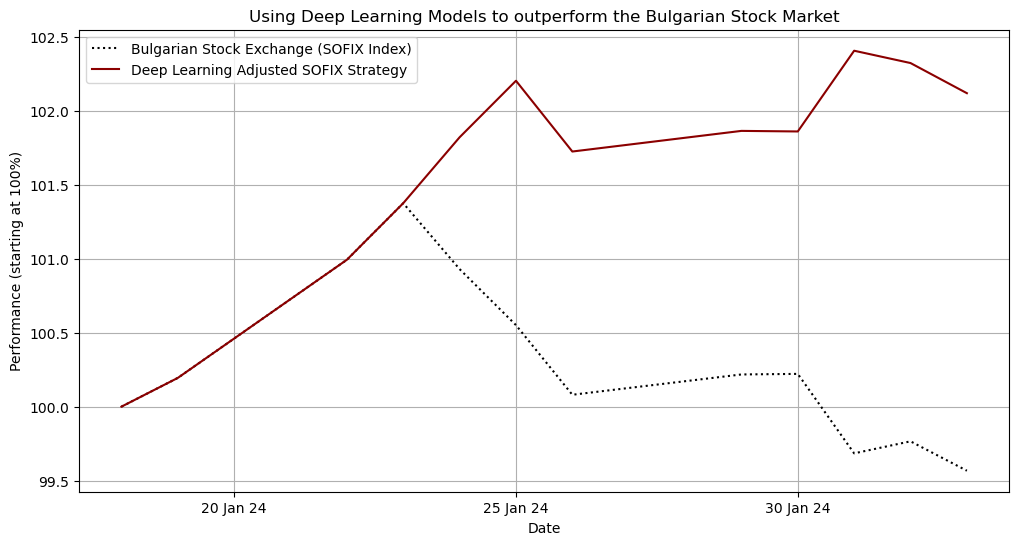

In [38]:
# Convert 'date' to datetime if it's not already
df_strategy_test['date'] = pd.to_datetime(df_strategy_test['date'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_strategy_test['date'], df_strategy_test['long_only_perf'], label='Bulgarian Stock Exchange (SOFIX Index)', linestyle=':', color='black')
plt.plot(df_strategy_test['date'], df_strategy_test['strategy_perf'], label='Deep Learning Adjusted SOFIX Strategy', color='darkred')

# Formatting the date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # adjust the interval as needed

# Adding titles and labels
plt.title('Using Deep Learning Models to outperform the Bulgarian Stock Market')
plt.xlabel('Date')
plt.ylabel('Performance (starting at 100%)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


#### What about Model 15? Remember it had only 30% accuracy on the test set! How will its predictions perform?

* The code below is similar to the previous but compiled into only 3 cells just so its quicker to run the code.

In [39]:
# Assuming you have a dictionary all_models_histories with models
model_key = 'config_config_1000,100,10,5,1_0.0001_epochs_25_reg_0_run_15'  # Replace with your actual model key
selected_model = all_models_histories[model_key]

# Assuming you have prepared your datasets as numpy arrays and stored them in a dictionary
datasets = {
    'X1_train': X1_train, 'X2_train': X2_train, 'y_train': y_train,
    'X1_cv': X1_cv, 'X2_cv': X2_cv, 'y_cv': y_cv,
    'X1_test': X1_test, 'X2_test': X2_test, 'y_test': y_test
}

def create_predictions_dataframe(model, datasets):
    df_probabilities = pd.DataFrame()

    for data_type in ['train', 'cv', 'test']:
        X1_data = datasets[f'X1_{data_type}'].astype('float32')
        X2_data = datasets[f'X2_{data_type}'].astype('float32')
        y_data = datasets[f'y_{data_type}'].astype('float32').flatten()

        probabilities = model.predict([X1_data, X2_data], verbose=0).flatten()
        predictions = (probabilities >= 0.5).astype(int)

        temp_df = pd.DataFrame({
            'up_down_prediction': predictions,
            'up_down_actual': y_data,
            'probability': probabilities,
            'data_set': data_type
        })

        # Calculate if prediction is correct
        temp_df['prediction_correct?'] = (temp_df['up_down_prediction'] == temp_df['up_down_actual']).astype(int)

        df_probabilities = pd.concat([df_probabilities, temp_df], ignore_index=True)

    return df_probabilities


# Original code to create DataFrame and calculate overall statistics
df_probabilities = create_predictions_dataframe(selected_model, datasets)

num_correct_predictions = df_probabilities['prediction_correct?'].sum()
total_predictions = len(df_probabilities)
accuracy = (num_correct_predictions / total_predictions) * 100

#add date column
df_probabilities['date'] = df_updown['date']

# Additional code to calculate and display statistics for each dataset type
for data_set in ['train', 'cv', 'test']:
    subset = df_probabilities[df_probabilities['data_set'] == data_set]
    num_correct_predictions_subset = subset['prediction_correct?'].sum()
    total_predictions_subset = len(subset)
    accuracy_subset = (num_correct_predictions_subset / total_predictions_subset) * 100 if total_predictions_subset > 0 else 0

    print(f"\n{data_set.upper()} Set - Number of correct predictions: {num_correct_predictions_subset}")
    print(f"{data_set.upper()} Set - Total number of predictions: {total_predictions_subset}")
    print(f"{data_set.upper()} Set - Accuracy of predictions: {accuracy_subset:.2f}%")


# Assuming df_intradays is your original dataframe
# Convert the 'date' column to datetime if it's not already
df_intradays['date'] = pd.to_datetime(df_intradays['date'])

# Filter rows where the time is 20:30:00
df_filtered = df_intradays[df_intradays['date'].dt.time == pd.to_datetime('10:30:00').time()]

# Remove the time part, leaving only the date in yyyy-mm-dd format
df_filtered['date'] = df_filtered['date'].dt.date
df_filtered = df_filtered.reset_index().drop(columns='index')
df_sofix_1030 = df_filtered


df_sofix_1030['level_eod'] = df_sofix['level']

df_sofix_1030['perf_close_1030'] = 0.0
df_sofix_1030 = df_sofix_1030.rename(columns={"level": "level_1030"})

# Iterating over the DataFrame rows starting from the second row (index 1)
for i in range(1, len(df_sofix_1030)):
    level_1030_current = df_sofix_1030.iloc[i]['level_1030']
    level_eod_previous = df_sofix_1030.iloc[i-1]['level_eod']
    df_sofix_1030.iloc[i, df_sofix_1030.columns.get_loc('perf_close_1030')] = (level_1030_current / level_eod_previous) - 1


# Initialize the index column
df_sofix_1030['index_close_1030'] = 100  # Starting value

# Iterating over the DataFrame rows
for i in range(1, len(df_sofix_1030)):
    # Calculate the new index value
    df_sofix_1030.loc[i, 'index_close_1030'] = df_sofix_1030.loc[i-1, 'index_close_1030'] * (1 + df_sofix_1030.loc[i, 'perf_close_1030'])

# Initialize the strategy index column
df_sofix_1030['strategy_index'] = 100  # Starting value

# Iterating over the DataFrame rows
for i in range(1, len(df_sofix_1030)):
    # Check the prediction from df_probabilities
    prediction = df_probabilities.loc[i-1, 'up_down_prediction']
    
    # Update the strategy index based on the prediction
    if prediction == 1:
        # If prediction is 1, multiply by (1 + perf_close_1030)
        df_sofix_1030.loc[i, 'strategy_index'] = df_sofix_1030.loc[i-1, 'strategy_index'] * (1 + df_sofix_1030.loc[i, 'perf_close_1030'])
    else:
        # If prediction is 0, also multiply by (1 + perf_close_1030)
        df_sofix_1030.loc[i, 'strategy_index'] = df_sofix_1030.loc[i-1, 'strategy_index'] * (1 - df_sofix_1030.loc[i, 'perf_close_1030'])

# Ensure the 'date' column in both dataframes is of datetime type
df_sofix_1030['date'] = pd.to_datetime(df_sofix_1030['date'])
df_probabilities['date'] = pd.to_datetime(df_probabilities['date'])

# Merge df_sofix_1030 with df_probabilities on 'date' to get the 'data_set' column
df_sofix_1030 = pd.merge(df_sofix_1030, df_probabilities[['date', 'data_set']], on='date', how='left')

df_sofix_1030['data_set'][0] = 'train'

df_strategy_train = df_sofix_1030[df_sofix_1030['data_set'] == 'train']

df_strategy_cv = df_sofix_1030[df_sofix_1030['data_set'] == 'cv']
df_strategy_cv = df_strategy_cv.reset_index().drop(columns = 'index')

df_strategy_test = df_sofix_1030[df_sofix_1030['data_set'] == 'test']
df_strategy_test = df_strategy_test.reset_index().drop(columns = 'index')



TRAIN Set - Number of correct predictions: 242
TRAIN Set - Total number of predictions: 243
TRAIN Set - Accuracy of predictions: 99.59%

CV Set - Number of correct predictions: 10
CV Set - Total number of predictions: 14
CV Set - Accuracy of predictions: 71.43%

TEST Set - Number of correct predictions: 4
TEST Set - Total number of predictions: 13
TEST Set - Accuracy of predictions: 30.77%


/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/3729690660.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = df_filtered['date'].dt.date
/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/3729690660.py:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '99.91382453349243' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sofix_1030.loc[i, 'index_close_1030'] = df_sofix_1030.loc[i-1, 'index_close_1030'] * (1 + df_sofix_1030.loc[i, 'perf_close_1030'])
/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/3729690660.py:107: FutureWarning: Setting an item of incompatible dtype 

#### Now lets plot the performance of run 15 on the CV set, as expected it looks good, but this is not the interesting part...

/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/1813768508.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '100.21021708957134' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_strategy_cv.loc[i, 'long_only_perf'] = df_strategy_cv.loc[i-1, 'long_only_perf'] * (1 + df_strategy_cv.loc[i, 'index_close_1030_pct_change'])
/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/1813768508.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '100.21021708957134' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_strategy_cv.loc[i, 'strategy_perf'] = df_strategy_cv.loc[i-1, 'strategy_perf'] * (1 + df_strategy_cv.loc[i, 'strategy_index_pct_change'])


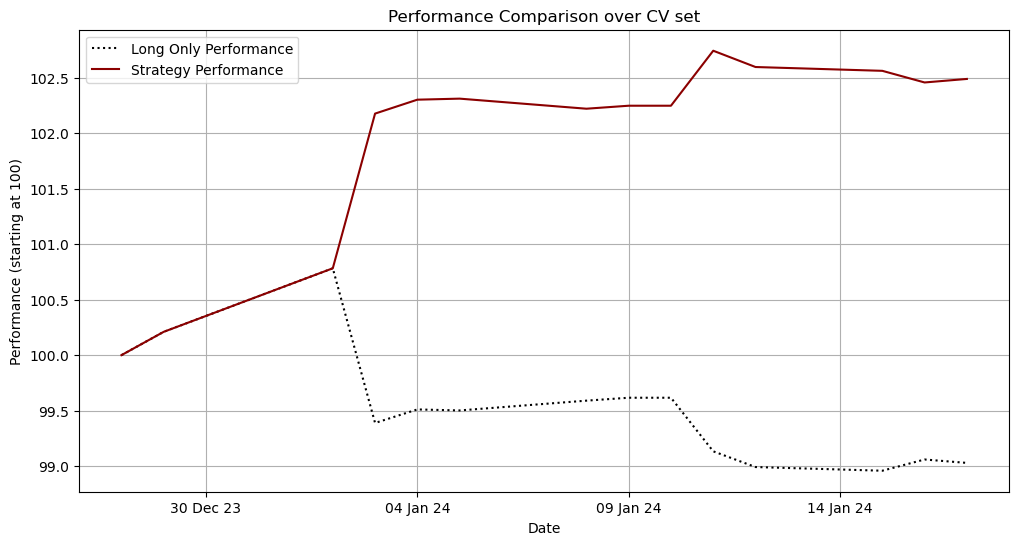

In [40]:
# We normalise the performances starting at 100 level for each of the data sets, in order to allow easier comparison. 
# We do this for both the long only performance and our strategy performance.

# Initialize the new columns with the starting value of 100
df_strategy_cv['long_only_perf'] = 100
df_strategy_cv['strategy_perf'] = 100

# Calculate the percentage changes in the original columns
df_strategy_cv['index_close_1030_pct_change'] = df_strategy_cv['index_close_1030'].pct_change()
df_strategy_cv['strategy_index_pct_change'] = df_strategy_cv['strategy_index'].pct_change()

# Apply the percentage changes to the new columns
for i in range(1, len(df_strategy_cv)):
    df_strategy_cv.loc[i, 'long_only_perf'] = df_strategy_cv.loc[i-1, 'long_only_perf'] * (1 + df_strategy_cv.loc[i, 'index_close_1030_pct_change'])
    df_strategy_cv.loc[i, 'strategy_perf'] = df_strategy_cv.loc[i-1, 'strategy_perf'] * (1 + df_strategy_cv.loc[i, 'strategy_index_pct_change'])

# Drop the temporary pct_change columns
df_strategy_cv.drop(['index_close_1030_pct_change', 'strategy_index_pct_change'], axis=1, inplace=True)

# Convert 'date' to datetime if it's not already
df_strategy_cv['date'] = pd.to_datetime(df_strategy_cv['date'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_strategy_cv['date'], df_strategy_cv['long_only_perf'], label='Long Only Performance', linestyle=':', color='black')
plt.plot(df_strategy_cv['date'], df_strategy_cv['strategy_perf'], label='Strategy Performance', color='darkred')

# Formatting the date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # adjust the interval as needed

# Adding titles and labels
plt.title('Performance Comparison over CV set')
plt.xlabel('Date')
plt.ylabel('Performance (starting at 100)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()



#### When we plot the performance of run 15 on the test set, it also outperforms the long only strategy! Despite the low accuracy! 
The reason for this is that the model makes the correct predictions for the most volatile days, which is the most important time to have a well performing strategy. Some days simply might not exhibit predictive characteristics. 

/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/3818538261.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '100.19427968554997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_strategy_test.loc[i, 'long_only_perf'] = df_strategy_test.loc[i-1, 'long_only_perf'] * (1 + df_strategy_test.loc[i, 'index_close_1030_pct_change'])
/var/folders/fq/yxnlx4k945q4643bb3fh_zzr0000gn/T/ipykernel_6926/3818538261.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '99.80572031445003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_strategy_test.loc[i, 'strategy_perf'] = df_strategy_test.loc[i-1, 'strategy_perf'] * (1 + df_strategy_test.loc[i, 'strategy_index_pct_change'])


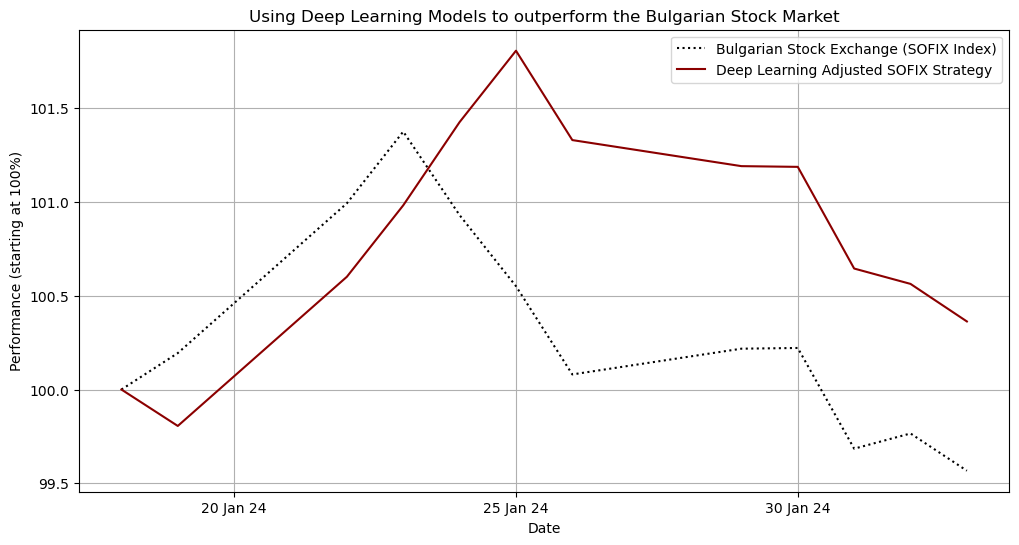

In [41]:
# Initialize the new columns with the starting value of 100
df_strategy_test['long_only_perf'] = 100
df_strategy_test['strategy_perf'] = 100

# Calculate the percentage changes in the original columns
df_strategy_test['index_close_1030_pct_change'] = df_strategy_test['index_close_1030'].pct_change()
df_strategy_test['strategy_index_pct_change'] = df_strategy_test['strategy_index'].pct_change()

# Apply the percentage changes to the new columns
for i in range(1, len(df_strategy_test)):
    df_strategy_test.loc[i, 'long_only_perf'] = df_strategy_test.loc[i-1, 'long_only_perf'] * (1 + df_strategy_test.loc[i, 'index_close_1030_pct_change'])
    df_strategy_test.loc[i, 'strategy_perf'] = df_strategy_test.loc[i-1, 'strategy_perf'] * (1 + df_strategy_test.loc[i, 'strategy_index_pct_change'])

# Drop the temporary pct_change columns
df_strategy_test.drop(['index_close_1030_pct_change', 'strategy_index_pct_change'], axis=1, inplace=True)


# Convert 'date' to datetime if it's not already
df_strategy_test['date'] = pd.to_datetime(df_strategy_test['date'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_strategy_test['date'], df_strategy_test['long_only_perf'], label='Bulgarian Stock Exchange (SOFIX Index)', linestyle=':', color='black')
plt.plot(df_strategy_test['date'], df_strategy_test['strategy_perf'], label='Deep Learning Adjusted SOFIX Strategy', color='darkred')

# Formatting the date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # adjust the interval as needed

# Adding titles and labels
plt.title('Using Deep Learning Models to outperform the Bulgarian Stock Market')
plt.xlabel('Date')
plt.ylabel('Performance (starting at 100%)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


#### A final comment:

You can re-run the above 3 cells to view the performance of any of our top 10 models and you will see they all outperform being long only!

So, what we have built is a methodology that produces several deep learning models all of which produce outputs that can be leveraged to build an investment strategy that can outperform going simply long the SOFIX Index (during the first 30 minutes of the exchange opening).

I think that is pretty cool :)